In [1]:
import pandas as pd
import numpy as np
#nn -- Linear, Module, MSELoss, ReLU, Sequential, Sigmoid
#optim -- adam
from torch import nn, optim
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn import metrics #confusion_matrix, classification_report, f1_score, recall_score, precision_score
import math, gc, copy

c:\ProgramData\Miniconda3\envs\fj\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Reading

In [2]:
df = pd.read_csv("../../Data/creditcard.csv")
del df["Time"]

zero = df[df["Class"] == 0].sample(frac = 1, random_state= 1234)
one = df[df["Class"] != 0]

train_df = zero[:int(round(zero.shape[0])*0.8)]
test_df = zero[int(round(zero.shape[0])*0.8):].append(one)

df["Amount"] = np.log(df["Amount"]+1).apply(lambda x: math.ceil(x * 10000)/10000)

gc.collect()

C:\Users\feifanjian\AppData\Local\Temp\ipykernel_38500\3305448385.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = zero[int(round(zero.shape[0])*0.8):].append(one)


0

In [3]:
train_x = train_df.drop(["Class"], axis=1)
train_y = train_df["Class"]

test_x = test_df.drop(["Class"], axis=1)
test_y = test_df["Class"]

In [4]:
train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32)
train_y = torch.tensor(train_y.to_numpy(), dtype=torch.float32)

test_x = torch.tensor(test_x.to_numpy(), dtype=torch.float32)
test_y = torch.tensor(test_y.to_numpy(), dtype=torch.float32)

## AutoEncoder Model

In [28]:
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        
        #returns a small negative value. This helps to avoid the "dying ReLU" problem
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16,8),
            nn.LeakyReLU(0.1)
            )
        
        self.mu = nn.Sequential(
            nn.Linear(8,4)
        )        
        self.sigma = nn.Sequential(
            nn.Linear(8,4)
        )      
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.LeakyReLU(0.1),
            nn.Linear(8, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16,input_dim)
            )
        
    def forward(self, x):
        encode = self.encoder(x)
        mean = self.mu(encode)
        log_var  = self.sigma(encode)
        epsilon = torch.distributions.normal.Normal(0, 1).sample(torch.Size([mean.shape[0], mean.shape[1]])).to(mean.device) #torch.randn_like(mean).to(mean.device)
        z = mean + torch.exp(0.5 * log_var) * epsilon
        decode = self.decoder(z)
        return decode


In [29]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

### Model Training

In [30]:
'''
model        Model to be trained
optimizer    Used to minimze errors
criterion    Used to compute errors
'''
seed = 1234
torch.manual_seed(seed)
input_dim = train_x.shape[1]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim).to(device)
es = EarlyStopping()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_x, batch_size=50, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_x, batch_size=1, shuffle=False, pin_memory=True)

In [31]:
epochs = 50
done = False
report =  pd.DataFrame(columns=['train loss', 'valid loss'])
report.index.name = "epoch"


for epoch in range(epochs):
    training_loss = 0.0
    training_counter = 0
    testing_loss = 0.0
    testing_counter = 0
    
    for data in train_loader:
        # Move data to device
        data = data.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data)
        # Loss calculation
        loss = criterion(outputs, data)
        # Backward propogation 
        loss.backward()
        # update the optimizer 
        optimizer.step()
        
        training_loss += loss.item()
        training_counter += 1
        
    
    with torch.no_grad():
        model.eval()
        for data in test_loader:
            data = data.to(device)
            preds = model(data)
            loss = criterion(preds, data)
            testing_loss += loss.item()
            testing_counter += 1
        if es(model, testing_loss):
                done = True
                
    if done:
        print(f"Early stopping triggered.")
        break
        
    report.loc[epoch,:] = [training_loss/training_counter, testing_loss/testing_counter]            
    print(f"Epoch: {epoch + 1}, train loss: {training_loss/training_counter:.4f}, test loss: {testing_loss/testing_counter:.4f}")


Epoch: 1, train loss: 26340171082170636435456.0000, test loss: 1141088.9107
Epoch: 2, train loss: 2559597012244850802688.0000, test loss: 2192642.3589
Epoch: 3, train loss: 34359165564861810737152.0000, test loss: 3261714.7940
Epoch: 4, train loss: 8629430653294826487808.0000, test loss: 6911922.0485
Epoch: 5, train loss: 130098559529109570977792.0000, test loss: 2572179.1465
Epoch: 6, train loss: 41142649711447913791488.0000, test loss: 1757183.6029
Epoch: 7, train loss: 406136787806220416.0000, test loss: 58260110.6194
Epoch: 8, train loss: 13934358011260759441408.0000, test loss: 686311.3081
Epoch: 9, train loss: 572892294437928828928.0000, test loss: 625058.9437
Epoch: 10, train loss: 19278938300435126026240.0000, test loss: 4584519.1506
Epoch: 11, train loss: 5921032953590240509952.0000, test loss: 3034084.6000
Epoch: 12, train loss: 3967221194923447943168.0000, test loss: 93997886.2301
Epoch: 13, train loss: 1545065423064795352924160.0000, test loss: 378865.3735
Epoch: 14, train 

In [36]:
thresholding_errors = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        preds = model(data)
        error = torch.mean(torch.square(preds - data), dim=1)
        thresholding_errors.extend(error.cpu().numpy())

KeyboardInterrupt: 

In [ ]:
#error_median = sorted(thresholding_errors)[len(thresholding_errors)//2]
#error_mean = np.mean(thresholding_errors)
#probability = [1/(1+np.exp(-x+error_mean)) for x in thresholding_errors]

In [ ]:
evaluation_df = pd.DataFrame({"thresholding_errors": thresholding_errors, "label": test_y})
thresholding_df = pd.DataFrame(columns=["threshold", "precision", "recall", "f1"])

for i in range(100, 1001, 50):
    threshold = sorted(thresholding_errors)[-i]
    evaluation_df["pred"] = np.where(evaluation_df.thresholding_errors >= threshold, 1, 0)
    thresholding_df.loc[len(thresholding_df),:] = [i, 
                        metrics.precision_score(evaluation_df["label"], evaluation_df["pred"]),
                        metrics.recall_score(evaluation_df["label"], evaluation_df["pred"]),
                        metrics.f1_score(evaluation_df["label"], evaluation_df["pred"]),
                        ]

c:\ProgramData\Miniconda3\envs\fj\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='threshold'>

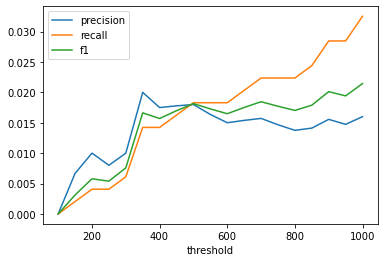

In [35]:
thresholding_df.plot(x = "threshold", y = ["precision", "recall", "f1"])

c:\ProgramData\Miniconda3\envs\fj\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='threshold'>

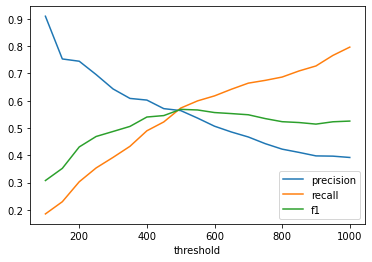

In [23]:
thresholding_df.plot(x = "threshold", y = ["precision", "recall", "f1"])